In [39]:
# Open TOPCAT
# Look for tables, check schema. SSA Service
# init git
# refactor in a module with commits
# configure ruff and autosave
# packaging
# precommit
# add tests with coverage
# add docs
# ci/cd with github actions

# Data retrieval


In [40]:
import pandas as pd
from astroquery.utils.tap.core import TapPlus

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

In [41]:
# Connect to the TAP service
tap = TapPlus(url="http://tap.roe.ac.uk/ssa")

adql = """
SELECT TOP 1000
    z.*,
    p.*
FROM BestDR9.ZooSpec AS z
JOIN BestDR7.PhotoObj AS p
  ON p.objid = z.dr7objid
"""

# Run synchronously
job = tap.launch_job(adql)
results = job.get_results()
df = results.to_pandas()

In [42]:
df

,specobjid,objid,dr7objid,ra,dec,rastring,decstring,nvote,p_el,p_cw,p_acw,p_edge,p_dk,p_mg,p_cs,p_el_debiased,p_cs_debiased,spiral,elliptical,uncertain,objID,skyVersion,run,rerun,camcol,field,obj,mode,nChild,type,clean,probPSF,insideMask,flags,rowc,rowcErr,colc,colcErr,rowv,rowvErr,colv,colvErr,rowc_u,rowc_g,rowc_r,rowc_i,rowc_z,rowcErr_u,rowcErr_g,rowcErr_r,rowcErr_i,rowcErr_z,colc_u,colc_g,colc_r,colc_i,colc_z,colcErr_u,colcErr_g,colcErr_r,colcErr_i,colcErr_z,sky_u,sky_g,sky_r,sky_i,sky_z,skyErr_u,skyErr_g,skyErr_r,skyErr_i,skyErr_z,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,fiberMagErr_u,fiberMagErr_g,fiberMagErr_r,fiberMagErr_i,fiberMagErr_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,petroMagErr_u,petroMagErr_g,petroMagErr_r,petroMagErr_i,petroMagErr_z,petroRad_u,petroRad_g,petroRad_r,petroRad_i,petroRad_z,petroRadErr_u,petroRadErr_g,petroRadErr_r,petroRadErr_i,petroRadErr_z,petroR50_u,petroR50_g,petroR50_r,petroR50_i,petroR50_z,petroR50Err_u,petroR50Err_g,petroR50Err_r,petroR50Err_i,petroR50Err_z,petroR90_u,petroR90_g,petroR90_r,petroR90_i,petroR90_z,petroR90Err_u,petroR90Err_g,petroR90Err_r,petroR90Err_i,petroR90Err_z,q_u,q_g,q_r,q_i,q_z,qErr_u,qErr_g,qErr_r,qErr_i,qErr_z,u_u,u_g,u_r,u_i,u_z,uErr_u,uErr_g,uErr_r,uErr_i,uErr_z,mE1_u,mE1_g,mE1_r,mE1_i,mE1_z,mE2_u,mE2_g,mE2_r,mE2_i,mE2_z,mE1E1Err_u,mE1E1Err_g,mE1E1Err_r,mE1E1Err_i,mE1E1Err_z,mE1E2Err_u,mE1E2Err_g,mE1E2Err_r,mE1E2Err_i,mE1E2Err_z,mE2E2Err_u,mE2E2Err_g,mE2E2Err_r,mE2E2Err_i,mE2E2Err_z,mRrCc_u,mRrCc_g,mRrCc_r,mRrCc_i,mRrCc_z,mRrCcErr_u,mRrCcErr_g,mRrCcErr_r,mRrCcErr_i,mRrCcErr_z,mCr4_u,mCr4_g,mCr4_r,mCr4_i,mCr4_z,mE1PSF_u,mE1PSF_g,mE1PSF_r,mE1PSF_i,mE1PSF_z,mE2PSF_u,mE2PSF_g,mE2PSF_r,mE2PSF_i,mE2PSF_z,mRrCcPSF_u,mRrCcPSF_g,mRrCcPSF_r,mRrCcPSF_i,mRrCcPSF_z,mCr4PSF_u,mCr4PSF_g,mCr4PSF_r,mCr4PSF_i,mCr4PSF_z,isoRowc_u,isoRowc_g,isoRowc_r,isoRowc_i,isoRowc_z,isoRowcErr_u,isoRowcErr_g,isoRowcErr_r,isoRowcErr_i,isoRowcErr_z,isoRowcGrad_u,isoRowcGrad_g,isoRowcGrad_r,isoRowcGrad_i,isoRowcGrad_z,isoColc_u,isoColc_g,isoColc_r,isoColc_i,isoColc_z,isoColcErr_u,isoColcErr_g,isoColcErr_r,isoColcErr_i,isoColcErr_z,isoColcGrad_u,isoColcGrad_g,isoColcGrad_r,isoColcGrad_i,isoColcGrad_z,isoA_u,isoA_g,isoA_r,isoA_i,isoA_z,isoAErr_u,isoAErr_g,isoAErr_r,isoAErr_i,isoAErr_z,isoB_u,isoB_g,isoB_r,isoB_i,isoB_z,isoBErr_u,isoBErr_g,isoBErr_r,isoBErr_i,isoBErr_z,isoAGrad_u,isoAGrad_g,isoAGrad_r,isoAGrad_i,isoAGrad_z,isoBGrad_u,isoBGrad_g,isoBGrad_r,isoBGrad_i,isoBGrad_z,isoPhi_u,isoPhi_g,isoPhi_r,isoPhi_i,isoPhi_z,isoPhiErr_u,isoPhiErr_g,isoPhiErr_r,isoPhiErr_i,isoPhiErr_z,isoPhiGrad_u,isoPhiGrad_g,isoPhiGrad_r,isoPhiGrad_i,isoPhiGrad_z,deVRad_u,deVRad_g,deVRad_r,deVRad_i,deVRad_z,deVRadErr_u,deVRadErr_g,deVRadErr_r,deVRadErr_i,deVRadErr_z,deVAB_u,deVAB_g,deVAB_r,deVAB_i,deVAB_z,deVABErr_u,deVABErr_g,deVABErr_r,deVABErr_i,deVABErr_z,deVPhi_u,deVPhi_g,deVPhi_r,deVPhi_i,deVPhi_z,deVPhiErr_u,deVPhiErr_g,deVPhiErr_r,deVPhiErr_i,deVPhiErr_z,deVMag_u,deVMag_g,deVMag_r,deVMag_i,deVMag_z,deVMagErr_u,deVMagErr_g,deVMagErr_r,deVMagErr_i,deVMagErr_z,expRad_u,expRad_g,expRad_r,expRad_i,expRad_z,expRadErr_u,expRadErr_g,expRadErr_r,expRadErr_i,expRadErr_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,expABErr_u,expABErr_g,expABErr_r,expABErr_i,expABErr_z,expPhi_u,expPhi_g,expPhi_r,expPhi_i,expPhi_z,expPhiErr_u,expPhiErr_g,expPhiErr_r,expPhiErr_i,expPhiErr_z,expMag_u,expMag_g,expMag_r,expMag_i,expMag_z,expMagErr_u,expMagErr_g,expMagErr_r,expMagErr_i,expMagErr_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,modelMagErr_u,modelMagErr_g,modelMagErr_r,modelMagErr_i,modelMagErr_z,texture_u,texture_g,texture_r,texture_i,texture_z,lnLStar_u,lnLStar_g,lnLStar_r,lnLStar_i,lnLStar_z,lnLExp_u,lnLExp_g,lnLExp_r,lnLExp_i,lnLExp_z,lnLDeV_u,lnLDeV_g,lnLDeV_r,lnLDeV_i,lnLDeV_z,fracDeV_u,fracDeV_g,fracDeV_r,fracDeV_i,fracDeV_z,flags_u,flags_g,flags_r,flags_i,flags_z,type_u,type_g,type_r,typ

In [43]:
def safe_to_numeric(col):
    try:
        return pd.to_numeric(col, errors="raise")
    except Exception:
        return col  # leave unchanged if it can't be fully parsed


df = df.apply(safe_to_numeric).set_index("dr7objid")

# Data filtering


In [44]:
mask = (
    # correct magnitudes
    (df["modelMag_u"] > -30)
    & (df["modelMag_g"] > -30)
    & (df["modelMag_r"] > -30)
    & (df["modelMag_i"] > -30)
    & (df["modelMag_z"] > -30)
    &
    # reasonable errors
    (df["modelMagErr_u"] < 0.5)
    & (df["modelMagErr_g"] < 0.05)
    & (df["modelMagErr_r"] < 0.05)
    & (df["modelMagErr_i"] < 0.05)
    & (df["modelMagErr_z"] < 0.1)
    &
    # very certain about the classification
    ((df["p_cs_debiased"] >= 0.9) | (df["p_el_debiased"] >= 0.9))
    &
    # medium size
    (df["petroR90_r"] * 2 * 1.5 / 0.4 < 64)
    & (df["petroR90_r"] * 2 / 0.4 > 20)
)

In [45]:
cols_to_keep = (
    [
        "specobjid",
        "objid",
        #"dr7objid",
        "ra",
        "dec",
        "p_el_debiased",
        "p_cs_debiased",
        "spiral",
        "elliptical",
    ]
    + ["petroR50_r", "petroR90_r"]
    + [f"modelMag_{f}" for f in "ugriz"]
    + [f"extinction_{f}" for f in "ugriz"]
)
df_filtered = df[mask][cols_to_keep]

In [46]:
df_filtered.head()

,specobjid,objid,ra,dec,p_el_debiased,p_cs_debiased,spiral,elliptical,petroR50_r,petroR90_r,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z
dr7objid,,,,,,,,,,,,,,,,,,,,
587724197201510613,470683366149089280,1237649918426415308,9.228958,13.894305,0.047,0.953,1,0,2.741955,6.363971,20.060163,18.611530,17.559286,17.019993,16.636461,0.312308,0.229793,0.166665,0.126377,0.089603
587724197202493564,471775455989491712,1237649918427398296,11.484458,13.812139,0.009,0.991,1,0,3.511922,7.065475,18.758015,17.559830,16.959278,16.575110,16.325520,0.401312,0.295282,0.214163,0.162393,0.115139
587724197203607681,472878816897820672,1237649918428512376,14.133875,13.698500,0.020,0.980,1,0,2.327382,7.055522,19.535625,17.923246,17.049698,16.570343,16.219820,0.358754,0.263968,0.191452,0.145172,0.102929
587724197740085400,472936541258278912,1237649918964990171,13.233209,14.169889,0.930,0.018,0,1,1.640008,4.498993,18.879148,17.071806,16.211632,16.047989,15.450515,0.316053,0.232549,0.168664,0.127893,0.090678
587724197740151092,472916200293165056,1237649918965055762,13.385917,14.069222,0.026,0.905,1,0,3.944560,7.731080,19.503391,18.208462,17.642393,17.308708,17.031727,0.343988,0.253103,0.183572,0.139197,0.098692


# Image cutout


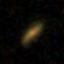

In [47]:
import urllib

from IPython.display import Image, display


IMAGE_PIXSCALE = 0.4  # arcsec/pixel
IMAGE_SIZE_PX = 64
IMAGE_WIDTH_PX = IMAGE_SIZE_PX
IMAGE_HEIGHT_PX = IMAGE_SIZE_PX
OBJECT_INDEX = 15  # which object from the filtered list to download

URL = (
    "https://skyserver.sdss.org/DR19/SkyserverWS/ImgCutout/getjpeg?"
    "ra={ra}&dec={dec}&scale={scale}&width={width}&height={height}"
)

RA = df_filtered.iloc[OBJECT_INDEX]["ra"]
DEC = df_filtered.iloc[OBJECT_INDEX]["dec"]


url = URL.format(ra=RA, dec=DEC, scale=IMAGE_PIXSCALE, width=IMAGE_WIDTH_PX, height=IMAGE_HEIGHT_PX)
response = urllib.request.urlopen(url)
blob = response.read()  # bytes of the image (JPEG)
display(Image(blob))